In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import kagglehub
# import statsmodels.api as sm

# import tensorflow_addons as tfa
import cv2
from keras import backend as K

from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import load_iris
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Activation, Concatenate
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.datasets import mnist
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import SparseCategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GroupShuffleSplit


import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from pydub import AudioSegment
from tqdm import tqdm
import tempfile

from tensorflow.keras import regularizers
tf.debugging.set_log_device_placement(False)

import numpy as np
import os
import re


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Metric

if os.path.isfile("myData.npz"):
    print("✅ 'data.npz' exists.")
    with np.load("myData.npz") as data:
        myData = data['myData']
        myData2 = data['myData2']
        myY = data['myY']
        myActors = data['myActors']
        myDatasets = data['myDatasets']
        myHasNoise = data['myHasNoise']
        print(np.unique(myY))
        print(np.unique(myActors))
else:

    folder = './savefiles'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j, 'has_noise': (j%4 == 0 or j%4==1)}

        return heatmaps_dict

    mfccwasserstein = findFilesFromPattern('wassersteinMfccHeat')
    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    print(len(mfccwasserstein))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]))
    print(len([mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    print(len(myRaw))

    myData = np.array([myRaw])
    print('finish data')
    myData = myData.astype('float32')
    myData = np.transpose(myData, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fearful':6, 'disgust':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[mfccwasserstein[key]['emotion']] -1 for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myY))
    myActors = np.array(
        [mfccwasserstein[key]['actor'] + '_' + mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [mfccwasserstein[key]['dataset']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    myHasNoise = np.array(
        [mfccwasserstein[key]['has_noise']  for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))
    myY = [x -1 if x > 0 else x for x in myY]
    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 0],
                        [mfccwasserstein[key]['data'] for key in sorted(mfccwasserstein.keys()) if mfccwasserstein[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float32')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)

    def upload_to_gcs(bucket_name, source_file, destination_blob):
        """Upload a file to a GCS bucket."""
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(destination_blob)
        blob.upload_from_filename(source_file)
        print(f"✅ Uploaded {destination_blob} to gs://{bucket_name}/{destination_blob}")

    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
        myHasNoise=myHasNoise
    )

    GCS_BUCKET = "simplicialcomplex-outputbucket"

    # upload_to_gcs(GCS_BUCKET, "myData.npz", "data/myData.npz")


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 'data.npz' exists.
[0. 1.]
['01_radvess' '02_radvess' '03_radvess' '04_radvess' '05_radvess'
 '06_radvess' '07_radvess' '08_radvess' '09_radvess' '1001_cremad'
 '1002_cremad' '1003_cremad' '1004_cremad' '1005_cremad' '1006_cremad'
 '1007_cremad' '1008_cremad' '1009_cremad' '1010_cremad' '1011_cremad'
 '1012_cremad' '1013_cremad' '1014_cremad' '1015_cremad' '1016_cremad'
 '1017_cremad' '1018_cremad' '1019_cremad' '1020_cremad' '1021_cremad'
 '1022_cremad' '1023_cremad' '1024_cremad' '1025_cremad' '1026_cremad'
 '1027_cremad' '1028_cremad' '1029_cremad' '1030_cremad' '1031_cremad'
 '1032_cremad' '1033_cremad' '1034_cremad' '1035_cremad' '1036_cremad'
 '1037_cremad' '1038_cremad' '1039_cremad' '1040_cremad' '1041_cremad'
 '1042_cremad' '1043_cremad' '1044_cremad' '1045_cremad' '1046_cremad'
 '1047_cremad' '1048_cremad' '1049_cremad' '1050_cremad' '1051_cremad'
 '1052_cremad' '1053_cremad' '1054_cremad' '1055_cremad' '1056_cremad'
 '1057_cremad' '1058_cremad' '1059_cremad' '1060_cremad' 

In [7]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1)
groups = myActors#np.array([f"{d}_{a}_{c}" for d, a, c in zip(myActors, myDatasets)])

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np

def stratified_group_split_3way(y, z, groups, val_size=0.2, test_size=0.2, random_state=42):
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({'y': y, 'z': z, 'group': groups})

    df["strat_label"] = df["y"].astype(str) + "_" + df["z"].astype(str)

    group_labels = (
        df.groupby('group')['y']
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )

    sss_inner = StratifiedShuffleSplit(
        n_splits=1, test_size=val_size/(1 - test_size), random_state=random_state + 1
    )

    group_indices = np.arange(len(group_labels))
    for trainval_g, test_g in sss_outer.split(group_indices, group_labels['y']):
        trainval_groups = group_labels['group'].iloc[trainval_g].values
        test_groups = group_labels['group'].iloc[test_g].values

        trainval_df = group_labels.iloc[trainval_g]
        trainval_idx = np.arange(len(trainval_df))

        for train_g, val_g in sss_inner.split(trainval_idx, trainval_df['y']):
            train_groups = trainval_df['group'].iloc[train_g].values
            val_groups = trainval_df['group'].iloc[val_g].values

    # Map back to samples
    train_mask = df['group'].isin(train_groups)
    val_mask = df['group'].isin(val_groups)
    test_mask = df['group'].isin(test_groups)

    train_idx = np.where(train_mask)[0]
    val_idx = np.where(val_mask)[0]
    test_idx = np.where(test_mask)[0]

    return train_idx, val_idx, test_idx

def stratified_group_split_cover_z_3way(
    y,
    z,
    groups,
    val_size=0.2,
    test_size=0.2,
    random_state=42,
    keep_size=True,
):
    """
    3-way group-wise split (train/val/test) with:
      - stratification by composite (y,z)
      - at least one of each z in test
      - no group overlap between splits

    Parameters
    ----------
    y : array-like
        Primary labels (e.g. emotion IDs)
    z : array-like
        Secondary variable (e.g. gender, dataset)
    groups : array-like
        Group IDs (e.g. actors)
    val_size : float
        Fraction of remaining groups for validation (after test split)
    test_size : float
        Fraction of all groups for test
    random_state : int
        RNG seed
    keep_size : bool
        Try to maintain split sizes even when adding missing z-groups
    """
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({"y": y, "z": z, "group": groups})

    # Composite stratification label
    df["strat"] = df["y"].astype(str) + "_" + df["z"].astype(str)

    # Majority composite per group
    grp = (
        df.groupby("group")["y"]
          .agg(lambda s: s.value_counts().index[0])
          .reset_index()
    )

    # --- Step 1: TrainVal/Test Split ---
    sss_outer = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    g_idx = np.arange(len(grp))
    for trainval_g_idx, test_g_idx in sss_outer.split(g_idx, grp["y"]):
        trainval_groups = set(grp["group"].iloc[trainval_g_idx])
        test_groups = set(grp["group"].iloc[test_g_idx])

    # --- Ensure all z categories appear in test ---
    all_z = set(df["z"].unique())
    def z_in_groups(gset):
        return set(df[df["group"].isin(gset)]["z"].unique())

    test_z = z_in_groups(test_groups)
    missing_z = list(all_z - test_z)

    if missing_z:
        g2count = df.groupby("group").size().to_dict()
        z_to_groups = {zv: set(df.loc[df["z"] == zv, "group"].unique()) for zv in all_z}

        for zv in missing_z:
            candidates = z_to_groups[zv] & trainval_groups
            if not candidates:
                continue
            g_chosen = min(candidates, key=lambda g: g2count.get(g, 0))
            trainval_groups.remove(g_chosen)
            test_groups.add(g_chosen)

            if keep_size:
                removable = []
                test_z_after = z_in_groups(test_groups)
                for g in list(test_groups - {g_chosen}):
                    tmp = test_groups.copy()
                    tmp.remove(g)
                    if z_in_groups(tmp) == test_z_after:
                        removable.append(g)
                if removable:
                    g_back = max(removable, key=lambda g: g2count.get(g, 0))
                    test_groups.remove(g_back)
                    trainval_groups.add(g_back)

    # --- Step 2: Train/Val Split (from remaining groups) ---
    subgrp = (
        df[df["group"].isin(trainval_groups)]
        .groupby("group")["y"]
        .agg(lambda s: s.value_counts().index[0])
        .reset_index()
    )

    sss_inner = StratifiedShuffleSplit(
        n_splits=1,
        test_size=val_size / (1 - test_size),
        random_state=random_state + 1,
    )
    g_idx_inner = np.arange(len(subgrp))
    for train_g_idx, val_g_idx in sss_inner.split(g_idx_inner, subgrp["y"]):
        train_groups = set(subgrp["group"].iloc[train_g_idx])
        val_groups = set(subgrp["group"].iloc[val_g_idx])

    # --- Map groups to sample indices ---
    train_idx = np.where(df["group"].isin(train_groups))[0]
    val_idx   = np.where(df["group"].isin(val_groups))[0]
    test_idx  = np.where(df["group"].isin(test_groups))[0]

    return train_idx, val_idx, test_idx




train_idx, val_idx, test_idx = stratified_group_split_cover_z_3way(y=np.argmax(myY, axis=1), z=myDatasets, groups=groups, val_size=0.2, test_size=0.2)

X_train, X_val, X_test, X_train2, X_val2, X_test2 = myData[train_idx], myData[val_idx], myData[test_idx], myData2[train_idx], myData2[val_idx], myData2[test_idx]
y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]


print(X_train.shape)
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
X_train2_tensor = torch.tensor(X_train2.transpose(0, 3, 1, 2), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

has_noise_idx = np.where(myHasNoise[val_idx] == 0)[0]
X_val_tensor = torch.tensor(X_val[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_val2_tensor = torch.tensor(X_val2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val[has_noise_idx], axis=1), dtype=torch.long)

has_noise_idx = np.where(myHasNoise[test_idx] == 0)[0]
X_test_tensor = torch.tensor(X_test[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
X_test2_tensor = torch.tensor(X_test2[has_noise_idx].transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test[has_noise_idx], axis=1), dtype=torch.long)


(13108, 128, 256, 1)


In [30]:


class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class CNNModel2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = CNNModel(64)
        self.model2 = CNNModel2(64)
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
    def forward(self, x1, x2):
        x1 = self.model(x1)
        x2 = self.model2(x2)
        x = torch.cat([x1, x2], dim=1)
        return self.classifier(x)

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (if any)
else:
    device = torch.device("cpu")   # fallback

In [31]:
np.unique(myActors[train_idx])

array(['01_radvess', '04_radvess', '05_radvess', '06_radvess',
       '08_radvess', '09_radvess', '1001_cremad', '1002_cremad',
       '1003_cremad', '1004_cremad', '1005_cremad', '1006_cremad',
       '1007_cremad', '1008_cremad', '1009_cremad', '1014_cremad',
       '1016_cremad', '1017_cremad', '1019_cremad', '1020_cremad',
       '1022_cremad', '1023_cremad', '1024_cremad', '1025_cremad',
       '1026_cremad', '1027_cremad', '1030_cremad', '1032_cremad',
       '1036_cremad', '1037_cremad', '1038_cremad', '1039_cremad',
       '1040_cremad', '1041_cremad', '1042_cremad', '1043_cremad',
       '1045_cremad', '1046_cremad', '1048_cremad', '1054_cremad',
       '1056_cremad', '1057_cremad', '1058_cremad', '1059_cremad',
       '1060_cremad', '1064_cremad', '1065_cremad', '1067_cremad',
       '1071_cremad', '1072_cremad', '1073_cremad', '1075_cremad',
       '1076_cremad', '1077_cremad', '1080_cremad', '1081_cremad',
       '1083_cremad', '1084_cremad', '1086_cremad', '1088_cremad',
 

In [32]:
np.unique(myActors[test_idx])

array(['02_radvess', '03_radvess', '1012_cremad', '1013_cremad',
       '1015_cremad', '1021_cremad', '1029_cremad', '1044_cremad',
       '1051_cremad', '1052_cremad', '1055_cremad', '1066_cremad',
       '1074_cremad', '1078_cremad', '1079_cremad', '1091_cremad',
       '10_radvess', '12_radvess', '13_radvess', '16_radvess',
       '17_radvess', '19_radvess', '23_radvess', 'JK_savee', 'OAF_tess'],
      dtype='<U11')

In [33]:
np.unique(myActors[val_idx])

array(['07_radvess', '1010_cremad', '1011_cremad', '1018_cremad',
       '1028_cremad', '1031_cremad', '1033_cremad', '1034_cremad',
       '1035_cremad', '1047_cremad', '1049_cremad', '1050_cremad',
       '1053_cremad', '1061_cremad', '1062_cremad', '1063_cremad',
       '1068_cremad', '1069_cremad', '1070_cremad', '1082_cremad',
       '1085_cremad', '1087_cremad', '14_radvess', 'DC_savee'],
      dtype='<U11')

In [34]:
np.unique(y_train)

array([0., 1.])

In [35]:

# --- Instantiate model ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


dataset = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True,
                          num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=256,num_workers=4,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test2_tensor, y_test_tensor), batch_size=256)



# model = CNNModel().to(device)
# model2 = CNNModel2().to(device)


# fusion = FusionNetGated().to(device)

model_comb = CombinedModel(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
# fusion_optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_combined = torch.optim.Adam(model_comb.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 25

best_val_auc = 0
auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model_comb.train()
    train_preds, train_labels = [], []
    for X_batch, X2_batch, y_batch in train_loader:
        X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
        # optimizer.zero_grad()
        # optimizer2.zero_grad()
        # fusion_optimizer.zero_grad()
        optimizer_combined.zero_grad()

        # outputs = model(X_batch)
        # outputs2 = model2(X2_batch)

        # combined_logits, alpha = fusion(outputs, outputs2)
        combined_logits = model_comb(X_batch, X2_batch)
        loss = criterion(combined_logits, y_batch)

        # optional deep supervision helps
        # loss = loss + 0.2*criterion(outputs, y_batch) + 0.2*criterion(outputs2, y_batch)
        loss.backward()

        train_preds.append(torch.softmax(combined_logits, dim=1))
        train_labels.append(y_batch)

        # optimizer.step()

        # optimizer2.step()

        # fusion_optimizer.step()

        optimizer_combined.step()

    # Validation
    model_comb.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, X2_val, y_val in val_loader:
            X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
            # outputs = model(X_val)
            # outputs2 = model2(X2_val)

            # combined_logits = fusion(outputs, outputs2)
            # combined_logits, alpha = fusion(outputs, outputs2)

            combined_logits = model_comb(X_val, X2_val)
            # loss = criterion(combined_logits, y_val)

            val_loss = criterion(combined_logits, y_val)
            preds = torch.softmax(combined_logits, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f} - val_loss {val_loss.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        # torch.save(model.state_dict(), "best_model_full.pth")
        # torch.save(model2.state_dict(), "best_model_full2.pth")
        # torch.save(fusion.state_dict(), "best_model_full3.pth")
        torch.save(model_comb.state_dict(), "best_model_comb.pth")
        print("✅ Saved new best model.")

    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)
    val_auc = auroc(train_preds, train_labels).item()
    val_top3 = top3acc(train_preds, train_labels).item()

    y_pred = torch.argmax(train_preds, dim=1)

    accuracy = (y_pred == train_labels).float().mean()
    print(f"Epoch {epoch+1}/{num_epochs} - train_auc: {val_auc:.4f} - train_top3_acc: {val_top3:.4f} - train_acc: {accuracy.item():.4f} - train_loss: {loss.item():.4f}")


Using device: mps
Epoch 1/25 - val_auc: 0.7505 - top3_acc: 0.7615 - val_acc: 0.3567 - val_loss 1.6245
✅ Saved new best model.
Epoch 1/25 - train_auc: 0.6675 - train_top3_acc: 0.6626 - train_acc: 0.2974 - train_loss: 1.4142
Epoch 2/25 - val_auc: 0.7863 - top3_acc: 0.7611 - val_acc: 0.3713 - val_loss 1.5541
✅ Saved new best model.
Epoch 2/25 - train_auc: 0.7989 - train_top3_acc: 0.8168 - train_acc: 0.4587 - train_loss: 1.3180
Epoch 3/25 - val_auc: 0.8091 - top3_acc: 0.7965 - val_acc: 0.4595 - val_loss 1.4413
✅ Saved new best model.
Epoch 3/25 - train_auc: 0.8462 - train_top3_acc: 0.8591 - train_acc: 0.5394 - train_loss: 1.4221
Epoch 4/25 - val_auc: 0.8022 - top3_acc: 0.7921 - val_acc: 0.3838 - val_loss 1.7514
Epoch 4/25 - train_auc: 0.8730 - train_top3_acc: 0.8832 - train_acc: 0.5874 - train_loss: 1.2575
Epoch 5/25 - val_auc: 0.7798 - top3_acc: 0.8067 - val_acc: 0.4188 - val_loss 1.4534
Epoch 5/25 - train_auc: 0.8885 - train_top3_acc: 0.9029 - train_acc: 0.6238 - train_loss: 1.1930
Epoch

Epoch 25/25 - val_auc: 0.8291 - top3_acc: 0.8401 - val_acc: 0.4844
              precision    recall  f1-score   support

     neutral       0.63      0.32      0.42       434
       happy       0.39      0.30      0.34       483
         sad       0.57      0.27      0.36       483
       angry       0.51      0.59      0.55       483
     fearful       0.37      0.80      0.51       483
     disgust       0.68      0.61      0.64       483

    accuracy                           0.48      2849
   macro avg       0.53      0.48      0.47      2849
weighted avg       0.52      0.48      0.47      2849



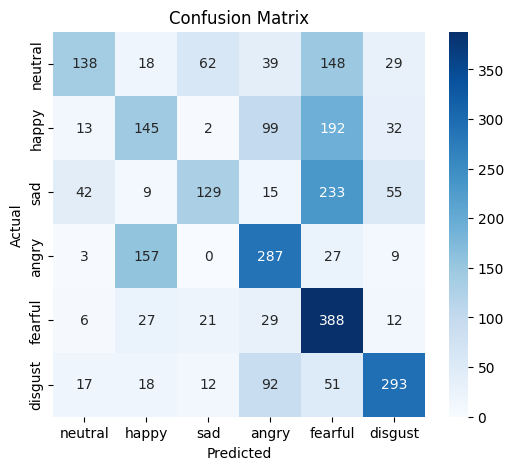

In [36]:

# ================================================================
# Evaluation
# ================================================================
# model.load_state_dict(torch.load("best_model_full.pth"))
# model2.load_state_dict(torch.load("best_model_full2.pth"))
# fusion.load_state_dict(torch.load("best_model_full3.pth"))
# model.eval()
# model2.eval()
# fusion.eval()
model_comb.load_state_dict(torch.load("best_model_comb.pth"))
model_comb.eval()\

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, X2_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X2_batch = X2_batch.to(device)
        # outputs = model(X_batch)
        # outputs2 = model2(X2_batch)

        # combined_logits = fusion(outputs, outputs2)
        # combined_logits = fusion(outputs, outputs2)
        combined_logits = model_comb(X_batch, X2_batch)
        # preds = torch.softmax(combined_logits, dim=1)
        preds = torch.argmax(combined_logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(combined_logits, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),  # for input 32×32 after two poolings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [18]:

dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256)

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 20

best_val_auc = 0.0

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_mel.pth")
        print("✅ Saved new best model.")


Epoch 1/25 - val_auc: 0.7155 - top3_acc: 0.6573 - val_acc: 0.2595
✅ Saved new best model.
Epoch 2/25 - val_auc: 0.8226 - top3_acc: 0.8330 - val_acc: 0.4621
✅ Saved new best model.
Epoch 3/25 - val_auc: 0.8496 - top3_acc: 0.8711 - val_acc: 0.5128
✅ Saved new best model.
Epoch 4/25 - val_auc: 0.8013 - top3_acc: 0.8000 - val_acc: 0.3807
Epoch 5/25 - val_auc: 0.7663 - top3_acc: 0.7736 - val_acc: 0.3650
Epoch 6/25 - val_auc: 0.7246 - top3_acc: 0.6962 - val_acc: 0.2888
Epoch 7/25 - val_auc: 0.8698 - top3_acc: 0.8807 - val_acc: 0.5655
✅ Saved new best model.
Epoch 8/25 - val_auc: 0.7770 - top3_acc: 0.7133 - val_acc: 0.3598
Epoch 9/25 - val_auc: 0.7697 - top3_acc: 0.7549 - val_acc: 0.3535
Epoch 10/25 - val_auc: 0.7627 - top3_acc: 0.7031 - val_acc: 0.3436
Epoch 11/25 - val_auc: 0.8262 - top3_acc: 0.7611 - val_acc: 0.4094
Epoch 12/25 - val_auc: 0.7941 - top3_acc: 0.8201 - val_acc: 0.3984
Epoch 13/25 - val_auc: 0.8337 - top3_acc: 0.8486 - val_acc: 0.4841
Epoch 14/25 - val_auc: 0.8663 - top3_acc: 

Epoch 25/25 - val_auc: 0.9020 - top3_acc: 0.9098 - val_acc: 0.6402
              precision    recall  f1-score   support

     neutral       0.79      0.64      0.71       434
       happy       0.62      0.61      0.62       483
         sad       0.59      0.73      0.66       483
       angry       0.60      0.78      0.68       483
     fearful       0.63      0.63      0.63       483
     disgust       0.69      0.45      0.54       483

    accuracy                           0.64      2849
   macro avg       0.65      0.64      0.64      2849
weighted avg       0.65      0.64      0.64      2849



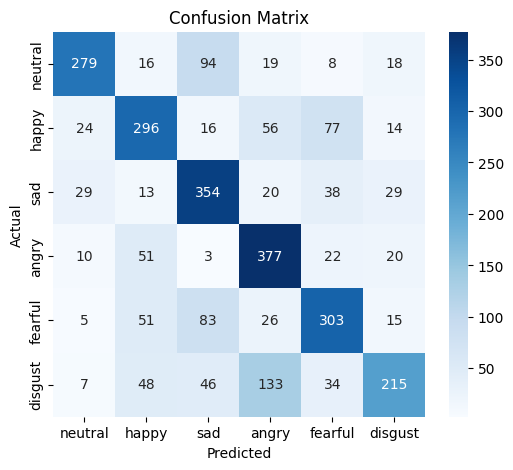

In [19]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model_mel.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
class CNNModel2(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [21]:

dataset = TensorDataset(X_train2_tensor, y_train_tensor)
val_ds = TensorDataset(X_val2_tensor, y_val_tensor)

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test2_tensor, y_test_tensor), batch_size=256)

model = CNNModel2().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 25

best_val_auc = 0.0

# ================================================================
# Training Loop with Checkpoint
# ================================================================
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            preds = torch.softmax(outputs, dim=1)
            val_preds.append(preds)
            val_labels.append(y_val)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)

    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_per.pth")
        print("✅ Saved new best model.")


Epoch 1/25 - val_auc: 0.7273 - top3_acc: 0.6876 - val_acc: 0.3003
✅ Saved new best model.
Epoch 2/25 - val_auc: 0.7542 - top3_acc: 0.7875 - val_acc: 0.3859
✅ Saved new best model.
Epoch 3/25 - val_auc: 0.7634 - top3_acc: 0.7938 - val_acc: 0.3854
✅ Saved new best model.
Epoch 4/25 - val_auc: 0.7710 - top3_acc: 0.8134 - val_acc: 0.4204
✅ Saved new best model.
Epoch 5/25 - val_auc: 0.7644 - top3_acc: 0.8278 - val_acc: 0.4010
Epoch 6/25 - val_auc: 0.7816 - top3_acc: 0.8127 - val_acc: 0.4407
✅ Saved new best model.
Epoch 7/25 - val_auc: 0.7665 - top3_acc: 0.8209 - val_acc: 0.4068
Epoch 8/25 - val_auc: 0.7694 - top3_acc: 0.8064 - val_acc: 0.4005
Epoch 9/25 - val_auc: 0.7790 - top3_acc: 0.8134 - val_acc: 0.4005
Epoch 10/25 - val_auc: 0.7683 - top3_acc: 0.8091 - val_acc: 0.4094
Epoch 11/25 - val_auc: 0.7835 - top3_acc: 0.8221 - val_acc: 0.4298
✅ Saved new best model.
Epoch 12/25 - val_auc: 0.7706 - top3_acc: 0.8071 - val_acc: 0.4099
Epoch 13/25 - val_auc: 0.7853 - top3_acc: 0.8273 - val_acc: 0

Epoch 25/25 - val_auc: 0.7790 - top3_acc: 0.8568 - val_acc: 0.4040
              precision    recall  f1-score   support

     neutral       0.45      0.39      0.42       434
       happy       0.35      0.32      0.33       483
         sad       0.47      0.68      0.56       483
       angry       0.37      0.38      0.38       483
     fearful       0.31      0.39      0.34       483
     disgust       0.56      0.26      0.35       483

    accuracy                           0.40      2849
   macro avg       0.42      0.40      0.40      2849
weighted avg       0.42      0.40      0.40      2849



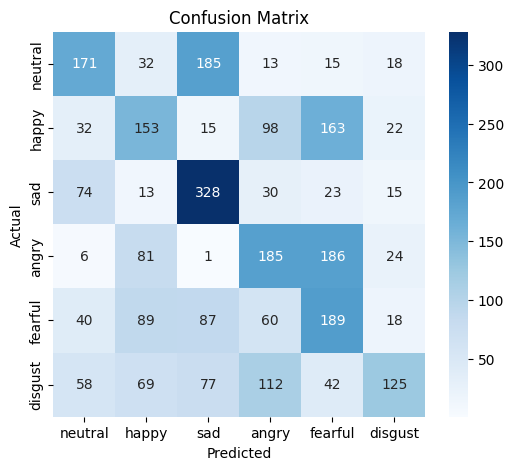

In [22]:

# ================================================================
# Evaluation
# ================================================================
model.load_state_dict(torch.load("best_model_per.pth"))
model.eval()

all_preds, all_labels, all_preds2, all_labels2 = [], [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_preds2.append(torch.softmax(outputs, dim=1))
        all_labels.extend(y_batch.numpy())
        all_labels2.append(y_batch.to(device))

    val_preds = torch.cat(all_preds2)
    val_labels = torch.cat(all_labels2)
    val_auc = auroc(val_preds, val_labels).item()
    val_top3 = top3acc(val_preds, val_labels).item()

    y_pred = torch.argmax(val_preds, dim=1)

    accuracy = (y_pred == val_labels).float().mean()

    print(f"Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f} - top3_acc: {val_top3:.4f} - val_acc: {accuracy.item():.4f}")


# Classification report
class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()